In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food-choices/food_coded.csv
/kaggle/input/food-choices/codebook_food.docx


# Objective

This project uses K-Means clustering to analyze the "Food Choices" dataset, identifying patterns in eating habits, exercise, income, and other lifestyle parameters. The goal is to group individuals into distinct clusters based on shared characteristics, enabling targeted insights and recommendations.

# Implementation Procedure

**> Import Libraries**

> Pandas, Matplotlib, Seaborn, Scikit learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

**> Download and mount the dataset (sourced from Kaggle)**

In [3]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("borapajo/food-choices")
print("Path to dataset files:", path)

# Load the dataset
df = pd.read_csv(f"{path}/food_coded.csv")  # Adjust path if necessary
print("Dataset Loaded:")
df.info()

Path to dataset files: /kaggle/input/food-choices
Dataset Loaded:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   GPA                           123 non-null    object 
 1   Gender                        125 non-null    int64  
 2   breakfast                     125 non-null    int64  
 3   calories_chicken              125 non-null    int64  
 4   calories_day                  106 non-null    float64
 5   calories_scone                124 non-null    float64
 6   coffee                        125 non-null    int64  
 7   comfort_food                  124 non-null    object 
 8   comfort_food_reasons          123 non-null    object 
 9   comfort_food_reasons_coded    106 non-null    float64
 10  cook                          122 non-null    float64
 11  comfort_food_reasons_coded.1  125 non-null    int64  
 12

**> Data Preprocessing**

> Cleaning and preparing the dataset by handling missing values, removing outliers, and normalizing the data. It ensures the data is suitable for clustering analysis.

In [4]:
# Select key parameters for analysis
selected_features = ['cook', 'eating_out', 'employment', 'ethnic_food', 'exercise', 'fruit_day', 'income', 'on_off_campus', 'pay_meal_out', 'sports', 'veggies_day']
df1 = df[selected_features]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
df1_imputed = pd.DataFrame(imputer.fit_transform(df1), columns=selected_features)

# Calculate the Interquartile Range (IQR)
Q1 = df1_imputed.quantile(0.25)
Q3 = df1_imputed.quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for each feature using the IQR method
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask to identify outliers (values outside the bounds)
outliers_mask = (df1_imputed < lower_bound) | (df1_imputed > upper_bound)

# Filter out rows with any outliers (where the mask is True)
df1_cleaned = df1_imputed[~outliers_mask.any(axis=1)]

# Reset the index after removing outliers
df1_cleaned = df1_cleaned.reset_index(drop=True)

# Normalize the data
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1_cleaned)

**> Exploratory Data Analysis**

> Creating a boxplot to visualize the distribution of food choices and lifestyle habits across various parameters after cleaning the data.

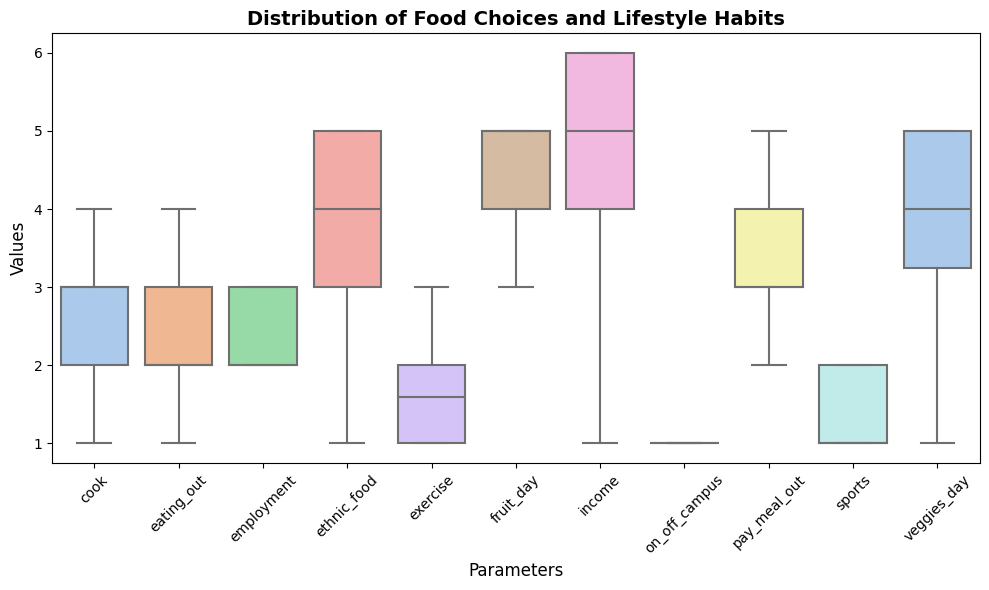

In [5]:
# Reshape the data for visualization by converting from wide to long format (melting)
df1_melted = df1_cleaned.melt(var_name='Parameters', value_name='Values')

plt.figure(figsize=(10, 6))

# Boxplot visualisation
sns.boxplot(data=df1_melted, x='Parameters', y='Values', palette='pastel')

# Plot title
plt.title('Distribution of Food Choices and Lifestyle Habits', fontsize=14, fontweight='bold')

# Label the x-axis (Parameters) and y-axis (Values)
plt.xlabel('Parameters', fontsize=12)
plt.ylabel('Values', fontsize=12)

# Rotate the x-axis labels to make them easier to read
plt.xticks(rotation=45)

# Adjust the layout to prevent clipping of labels and titles
plt.tight_layout()

# Display the plot
plt.show()

**> Find the optimal number of clusters (K-value)**

> Calculating silhouette scores for different values of K, identifying the optimal value for K, and visualizing the results.

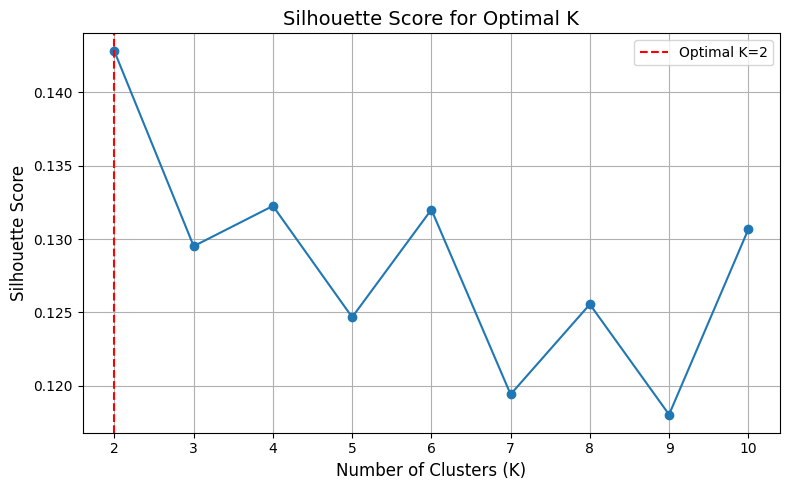


Optimal number of clusters (K): 2 with Silhouette Score: 0.1428


In [6]:
# Function to find the optimal K using silhouette scores
def find_optimal_k(data, k_range):
    sil_scores = []
    for k in k_range:
        try:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(data)
            sil_scores.append(silhouette_score(data, labels))
        except Exception as e:
            print(f"Error with K={k}: {e}")
            sil_scores.append(None)
    return sil_scores

# Define the range of K values
K_range = range(2, 11)

# Calculate silhouette scores
sil_scores = find_optimal_k(df1_scaled, K_range)

# Identify optimal K
optimal_k, max_score = max(zip(K_range, sil_scores), key=lambda x: x[1])

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, marker='o')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
plt.title('Silhouette Score for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"\nOptimal number of clusters (K): {optimal_k} with Silhouette Score: {max_score:.4f}")

**> Apply K-Means Clustering**

> Applying K-Means clustering with the optimal number of clusters (here, 2), summarizing each cluster's characteristics (mean, standard deviation, size), and displays the results.

In [7]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Assign cluster labels to the dataset
df1_cleaned['Cluster'] = kmeans.fit_predict(df1_scaled)

# Generate cluster summary: Calculate mean and standard deviation for each cluster
cluster_stats = df1_cleaned.groupby('Cluster').agg(['mean', 'std'])

# Add the cluster size to the summary
cluster_sizes = df1_cleaned['Cluster'].value_counts().sort_index()
cluster_stats['Size'] = cluster_sizes.values

# Display cluster characteristics
print("\nCluster Characteristics:")
print(cluster_stats)

# Optional: Output the cluster centers for reference
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df1_cleaned.columns[:-1])
print("\nCluster Centers:")
print(cluster_centers)


Cluster Characteristics:
             cook           eating_out           employment            \
             mean       std       mean       std       mean       std   
Cluster                                                                 
0        2.750820  0.882292   2.266667  0.863397   2.363218  0.468705   
1        2.820237  0.758483   2.448276  0.783135   2.448276  0.506120   

        ethnic_food            exercise            ...    income  \
               mean       std      mean       std  ...       std   
Cluster                                            ...             
0          4.044444  1.043498  1.345238  0.493596  ...  1.529371   
1          3.206897  1.235756  2.006158  0.740084  ...  1.369981   

        on_off_campus      pay_meal_out              sports            \
                 mean  std         mean       std      mean       std   
Cluster                                                                 
0                 1.0  0.0     3.111111  0.68165

**> Cluster Visualization (K = 2)**

>Reshaping the data for visualization and creating a boxplot to analyze the distribution of parameters across clusters.

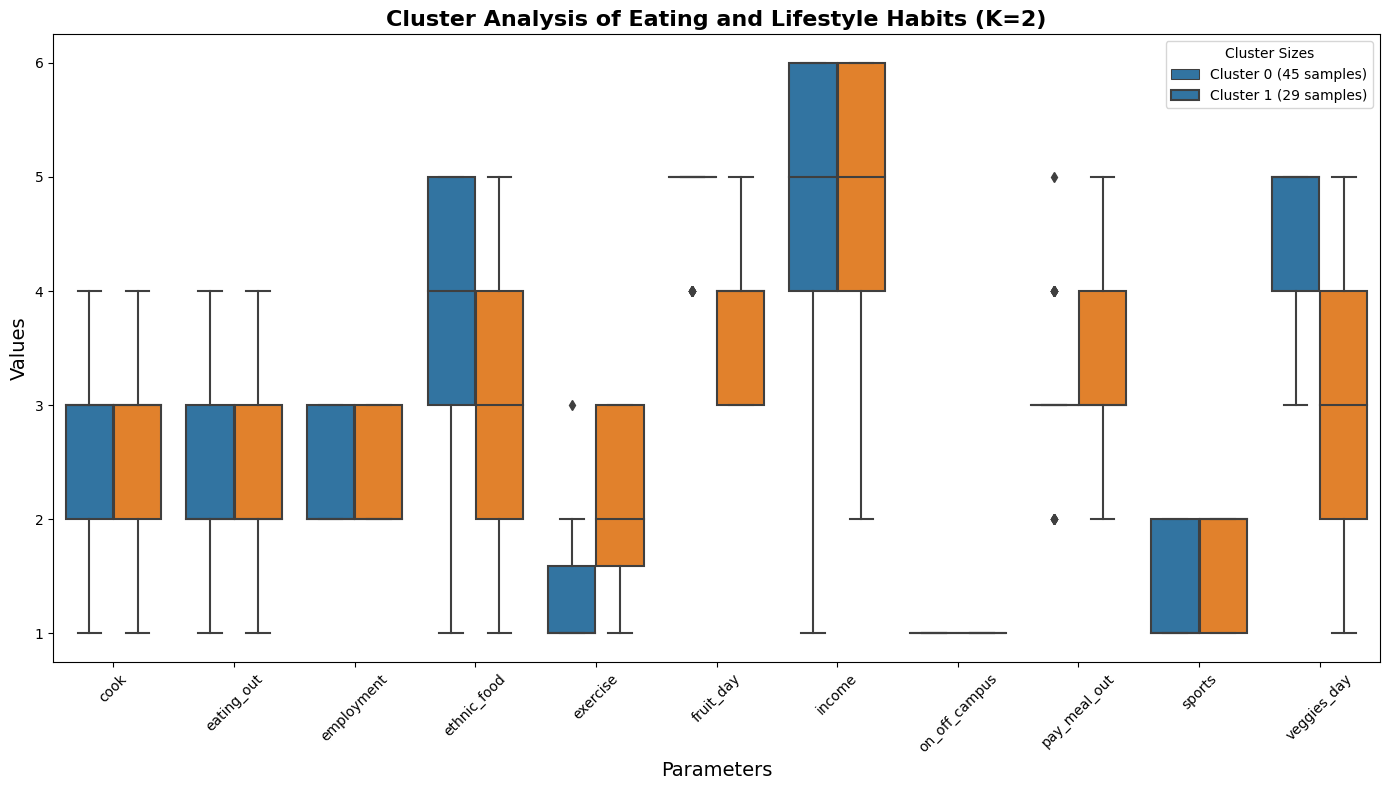

In [8]:
# Reshape data for visualization
df1_melted = df1_cleaned.melt(id_vars='Cluster', var_name='Parameters', value_name='Values')

plt.figure(figsize=(14, 8))
sns.boxplot(data=df1_melted, x='Parameters', y='Values', hue='Cluster', palette='tab10')
plt.title(f'Cluster Analysis of Eating and Lifestyle Habits (K={optimal_k})', fontsize=16, fontweight='bold')
plt.xlabel('Parameters', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title=f'Cluster Sizes', labels=[f"Cluster {c} ({cluster_sizes[c]} samples)" for c in cluster_sizes.index])
plt.tight_layout()
plt.show()

# Achievements

1. *Data-Driven Segmentation:* Groups individuals based on income, eating habits, and lifestyle choices for tailored strategies.

2. *Actionable Recommendations:*
a. Businesses: Target marketing and product development for specific clusters.
b. Health Sector: Design interventions for at-risk populations.
c. Researchers: Use cluster insights to study behavioral patterns.

3. *Optimization:* Automated 𝐾 selection ensures robust clustering, enhancing the reliability of recommendations.

# Conclusion

This project analyzed eating and lifestyle habits using K-Means clustering, grouping individuals into distinct clusters based on factors like income, exercise frequency, and dietary preferences. The optimal number of clusters was identified using silhouette scores, revealing patterns such as high-income groups with balanced diets and active lifestyles. Insights from the analysis can guide personalized nutrition plans, health campaigns, and targeted marketing strategies. Key learnings included handling missing data, normalizing datasets, and using visualization tools to communicate results effectively, showcasing the practical applications of Python and machine learning.